In [1]:
from dataloader import DataLoader
loader = DataLoader()

###################################################
# Data Loading
###################################################
df = loader.get_data()

_initialize_data took 99.7553 seconds


In [2]:
import polars as pl
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import pandas as pd
from tqdm import tqdm
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings
warnings.filterwarnings("ignore")

###################################################
# Parameters
###################################################
edge_feature_cols = [
    "diplo_disagreement",   # diplomatic disagreement
    "q",                    # volume of trade-flow
    "v",                    # value of trade-flow
    "comrelig",             # common religion
    "comlang_off",          # common official language
    "distw_harmonic",       # distance between countries (harmonic)
    "pop_o",                # population origin (export) country
    "pop_d",                # population destination (import) country
    "gatt_o",               # general agreement on tariffs and trade (gatt) origin (export) country
    "gatt_d",               # general agreement on tariffs and trade (gatt) destination (import) country
    "wto_o",                # member of world trade organisation (wto) origin (export) country
    "wto_d",                # member of world trade organisation (wto) destination (import) country 
    "eu_o",                 # member of european union (eu) origin (export) country
    "eu_d",                 # member of european union (eu) destination (import) country
    "fta_wto",              # free trade agreement (fta), world trade organisation (wto)
    "entry_cost_o",         # trade entry costs of origin (export) country 
    "entry_cost_d",         # trade entry costs of destination (import) country 
    "tradeflow_baci",       # tradeflow between exporter and importer as reported by baci
    "tradeflow_imf_o",      # tradeflow of origin (export) country reported by the international monetary fund (imf)
    "tradeflow_imf_d",      # tradeflow of destination (import) country reported by the international monetary fund (imf)
]

###################################################
# Training Features and Details
###################################################
start_year = 2015
n_folds = 5        
epochs = 100       
lr = 0.01

adj_loss_weight = 0.5
attr_loss_weight = 0.5

# DEVICE
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [20]:
###################################################
# Helper Functions
###################################################
def prepare_graph_data(pdf, all_countries, edge_feature_cols, scaler=None):
    """
    Convert a filtered pandas DataFrame into a PyTorch Geometric Data object.

    Parameters
    ----------
    pdf : pd.DataFrame
        Filtered DataFrame for a given product-year subset.
    all_countries : np.ndarray
        Array of all unique country codes encountered.
    edge_feature_cols : list of str
        List of edge feature column names.
    scaler : StandardScaler, optional
        A fitted scaler to transform edge features. If None, no scaling is applied.

    Returns
    -------
    (edge_index, edge_attr) : (torch.Tensor, torch.Tensor)
        edge_index: shape [2, num_edges], edge_attr: shape [num_edges, num_features]
    """
    country_to_id = {c: i for i, c in enumerate(all_countries)}
    
    def map_countries(series):
        return series.map(country_to_id)
    
    src = map_countries(pdf['export_country'])
    dst = map_countries(pdf['import_country'])
    edge_index = torch.tensor([src.values, dst.values], dtype=torch.long)
    
    for col in edge_feature_cols:
        pdf[col] = pdf[col].fillna(0.0).astype(float)
        
    edge_attr_values = pdf[edge_feature_cols].values
    if scaler is not None:
        edge_attr_values = scaler.transform(edge_attr_values)
    edge_attr = torch.tensor(edge_attr_values, dtype=torch.float)
    return edge_index, edge_attr

In [22]:
###################################################
# Graph Network
###################################################
class GCNEncoder(nn.Module):
    """
    A GCN-based encoder that processes node features and graph structure to produce node embeddings.

    This encoder applies two successive GCNConv layers with ReLU activation and dropout for regularization.
    It takes as input a node feature matrix and an edge index, and outputs a transformed embedding for each node.

    Parameters
    ----------
    in_channels : int
        Dimensionality of the input node features.
    hidden_dim : int, optional (default=64)
        Number of hidden units in the first GCN layer.
    out_channels : int, optional (default=32)
        Number of output embedding dimensions for the nodes.
    dropout : float, optional (default=0.1)
        Dropout probability applied to the activations after the first GCN layer.

    Forward Parameters
    ------------------
    x : torch.Tensor
        Node feature matrix of shape [num_nodes, in_channels].
    edge_index : torch.Tensor
        Graph connectivity in COO format, with shape [2, num_edges].

    Returns
    -------
    torch.Tensor
        Node embeddings of shape [num_nodes, out_channels].
    """
    def __init__(self, in_channels, hidden_dim=64, out_channels=32, dropout=0.1):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_channels)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x


class TemporalGNN(nn.Module):
    """
    A temporal graph neural network that encodes a sequence of graph snapshots and aggregates them over time.

    This model first uses a GCNEncoder to compute node embeddings for each graph snapshot.
    It then uses an LSTM to aggregate these embeddings over multiple time steps, producing a final temporal embedding
    for each node. The final output is a node embedding that captures both structural and temporal information.

    Parameters
    ----------
    in_channels : int
        Dimensionality of the input node features for each snapshot.
    out_channels : int, optional (default=32)
        Number of output embedding dimensions after temporal aggregation.
    hidden_dim : int, optional (default=64)
        Number of hidden units in the GCN and the LSTM layers.
    dropout : float, optional (default=0.1)
        Dropout probability applied after the first GCN layer.

    Forward Parameters
    ------------------
    x_list : list of torch.Tensor
        A list of node feature matrices, one per time step. Each element has shape [num_nodes, in_channels].
    edge_index_list : list of torch.Tensor
        A list of edge_index tensors corresponding to each time step. Each has shape [2, num_edges].

    Returns
    -------
    torch.Tensor
        A tensor of node embeddings of shape [num_nodes, out_channels], representing the temporal aggregation of the input graphs.
    """
    def __init__(self, in_channels, out_channels=32, hidden_dim=64, dropout=0.1):
        super().__init__()
        self.gcn = GCNEncoder(in_channels, hidden_dim=hidden_dim, out_channels=out_channels, dropout=dropout)
        self.lstm = nn.LSTM(out_channels, out_channels, batch_first=True)
        
    def forward(self, x_list, edge_index_list):
        z_seq = []
        for i in range(len(x_list)):
            z_year = self.gcn(x_list[i], edge_index_list[i])
            z_seq.append(z_year.unsqueeze(1))
        z_cat = torch.cat(z_seq, dim=1)
        
        output, (h, c) = self.lstm(z_cat)
        z_final = h.squeeze(0)
        return z_final


class EdgeDecoder(nn.Module):
    """
    A decoder that predicts edge existence and the 'v' attribute (i.e., trade value) from node embeddings.

    Given node embeddings and an edge index, this decoder first computes an edge score indicating the likelihood
    that an edge exists between the two nodes. It also predicts a continuous attribute 'v' for that edge
    by processing the concatenation of the two node embeddings.

    Parameters
    ----------
    emb_dim : int
        Dimensionality of the node embeddings.

    Forward Parameters
    ------------------
    z : torch.Tensor
        Node embeddings of shape [num_nodes, emb_dim].
    edge_index : torch.Tensor
        Indices of edges for which we want to predict existence and the 'v' attribute, shape [2, num_edges].

    Returns
    -------
    edge_prob : torch.Tensor
        Probabilities of edge existence, shape [num_edges].
    v_pred : torch.Tensor
        Predicted 'v' values for each edge, shape [num_edges].
    """
    def __init__(self, emb_dim):
        super().__init__()
        self.adj_bias = nn.Parameter(torch.zeros(1))
        self.mlp = nn.Sequential(
            nn.Linear(2 * emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def forward(self, z, edge_index):
        u = edge_index[0]
        v = edge_index[1]
        z_u = z[u]
        z_v = z[v]
        
        ################################
        # Edge existence probability
        ################################
        scores = (z_u * z_v).sum(dim=-1) + self.adj_bias
        edge_prob = torch.sigmoid(scores)

        ################################
        # Prediction of the volume (v)
        ################################
        edge_input = torch.cat([z_u, z_v], dim=-1)
        v_pred = self.mlp(edge_input).squeeze(-1)

        return edge_prob, v_pred


class GAEModel(nn.Module):
    """
    A Graph Autoencoder (GAE) model that combines a temporal GCN-based encoder and an edge decoder.

    This model encodes multiple graph snapshots (or a single snapshot) using an encoder such as TemporalGNN,
    and then uses an EdgeDecoder to reconstruct edge existence and the 'v' attribute. It provides methods
    for computing reconstruction loss with positive and negative edges, enabling anomaly detection and/or link prediction.

    Parameters
    ----------
    encoder : nn.Module
        An encoder module that takes a sequence of graphs (or a single graph) and produces node embeddings.
    decoder : nn.Module
        A decoder module that, given node embeddings, predicts edge existence and 'v' attributes.

    Forward Parameters
    ------------------
    x : torch.Tensor or list of torch.Tensor
        Node feature matrix (or a list of matrices for multiple time steps).
    edge_index : torch.Tensor or list of torch.Tensor
        Edge indices (or a list of edge indices for multiple time steps).

    Returns
    -------
    tuple(torch.Tensor, torch.Tensor)
        edge_prob and v_pred as returned by the decoder.
    """
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    
    def encode(self, x_list, edge_index_list):
        """
        Encodes the input graphs into node embeddings.

        Parameters
        ----------
        x_list : list of torch.Tensor
            List of node feature matrices, one per time step or a single time step.
        edge_index_list : list of torch.Tensor
            List of edge index tensors, one per time step or a single time step.

        Returns
        -------
        torch.Tensor
            Node embeddings of shape [num_nodes, embedding_dim].
        """
        return self.encoder(x_list, edge_index_list)
    
    
    def forward(self, x, edge_index):
        """
        Forward pass to encode the input and decode edges.

        Parameters
        ----------
        x : torch.Tensor or list of torch.Tensor
            Node features.
        edge_index : torch.Tensor or list of torch.Tensor
            Edge indices.

        Returns
        -------
        edge_prob : torch.Tensor
            Predicted probabilities of edge existence.
        v_pred : torch.Tensor
            Predicted 'v' values for each edge.
        """
        z = self.encode(x, edge_index)
        return self.decoder(z, edge_index)


    def recon_loss(self, z, edge_index, edge_attr, v_index):
        """
        Computes reconstruction loss from positive edges only, using both adjacency and 'v' attribute reconstruction.

        Parameters
        ----------
        z : torch.Tensor
            Node embeddings.
        edge_index : torch.Tensor
            Edge indices.
        edge_attr : torch.Tensor
            Original edge attributes, shape [num_edges, num_features].
        v_index : int
            The column index of 'v' in the edge attributes array.

        Returns
        -------
        torch.Tensor
            Scalar loss value representing the sum of adjacency BCE loss and MSE loss for 'v'.
        """
        edge_prob, v_pred = self.decoder(z, edge_index)

        adj_loss = F.binary_cross_entropy(edge_prob, torch.ones_like(edge_prob))

        v_true = edge_attr[:, v_index]
        v_loss = F.mse_loss(v_pred, v_true)

        return adj_loss + v_loss
    
    
    def recon_loss_with_neg(self, z, pos_edge_index, neg_edge_index, pos_edge_attr, v_index, adj_weight=0.5, attr_weight=0.5):
        """
        Compute the reconstruction loss using both positive and negative edges.

        This method includes:
        - Adjacency loss (BCE) computed on positive edges (target=1) and negative edges (target=0).
        - Attribute loss (MSE) computed only on positive edges for the 'v' attribute.
        The final loss is a weighted combination of adjacency and attribute losses.

        Parameters
        ----------
        z : torch.Tensor
            Node embeddings of shape [num_nodes, embedding_dim].
        pos_edge_index : torch.Tensor
            Edge indices for observed (positive) edges, shape [2, num_positive_edges].
        neg_edge_index : torch.Tensor
            Edge indices for sampled non-edges (negative), shape [2, num_negative_edges].
        pos_edge_attr : torch.Tensor
            Attributes of the positive edges, shape [num_positive_edges, num_features].
        v_index : int
            The index of 'v' in pos_edge_attr.
        adj_weight : float, optional (default=0.5)
            Weight for the adjacency reconstruction loss.
        attr_weight : float, optional (default=0.5)
            Weight for the attribute ('v') reconstruction loss.

        Returns
        -------
        torch.Tensor
            A scalar loss value representing the weighted sum of adjacency and attribute reconstruction losses.
        """
        pos_edge_prob, pos_v_pred = self.decoder(z, pos_edge_index)
        neg_edge_prob, _ = self.decoder(z, neg_edge_index)
    
        pos_adj_loss = F.binary_cross_entropy(pos_edge_prob, torch.ones_like(pos_edge_prob))
        neg_adj_loss = F.binary_cross_entropy(neg_edge_prob, torch.zeros_like(neg_edge_prob))
        adj_loss = (pos_adj_loss + neg_adj_loss) / 2.0
    
        v_true = pos_edge_attr[:, v_index]
        v_loss = F.mse_loss(pos_v_pred, v_true)
    
        return adj_weight * adj_loss + attr_weight * v_loss

In [ ]:
def train_model(model, 
                train_data_list, 
                v_index, 
                epochs=100, 
                lr=0.01, 
                device=torch.device("cpu"), 
                adj_weight=0.5, 
                attr_weight=0.5, 
                weight_decay=1e-4):
    """
    Train the GAE model on a sequence of historical graphs plus a target year's graph, 
    focusing on reconstructing the 'v' attribute for the target year. 
    This involves temporal encoding of historical data followed by reconstruction 
    of the target year's edges. Negative samples (non-existent edges) are generated 
    randomly to help the model distinguish actual edges from non-edges.

    Parameters
    ----------
    model : GAEModel
        The GAE model to train. It should be capable of encoding multiple 
        historical graphs and then decoding the target year's edges.
    train_data_list : list of tuples
        A list of length window_size+1, where each element is 
        (x, edge_index, edge_attr) for one year's graph.
        The last element corresponds to the target year.
    v_index : int
        Index of 'v' in edge_attr arrays, indicating which attribute is the 'v' attribute.
    epochs : int, optional (default=100)
        Number of training epochs.
    lr : float, optional (default=0.01)
        Learning rate for the optimizer.
    device : torch.device, optional (default=CPU)
        Device to run computations on (CPU or GPU).
    adj_weight : float, optional (default=0.5)
        Weight assigned to the adjacency reconstruction loss.
    attr_weight : float, optional (default=0.5)
        Weight assigned to the attribute (v) reconstruction loss.
    weight_decay : float, optional (default=1e-4)
        L2 regularization term for the optimizer.

    Returns
    -------
    None
        Trained in-place.
    """
    
    model.to(device)
    
    # Node and edge features for all years
    x_list = [d[0].to(device) for d in train_data_list[:-1]]
    edge_index_list = [d[1].to(device) for d in train_data_list[:-1]]
    
    # Target year data
    target_data = train_data_list[-1]
    target_x = target_data[0].to(device)
    target_edge_index = target_data[1].to(device)
    target_edge_attr = target_data[2].to(device)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    model.train()
    
    torch.autograd.set_detect_anomaly(True)
    
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        z = model.encode(x_list + [target_x], edge_index_list + [target_edge_index])
        
        # Random negative sampling
        neg_edge_index = negative_sampling(
            edge_index=target_edge_index,
            num_nodes=target_x.size(0),
            num_neg_samples=target_edge_index.size(1)
        ).to(device)
        
        loss = model.recon_loss_with_neg(
            z, 
            target_edge_index, 
            neg_edge_index, 
            target_edge_attr, 
            v_index, 
            adj_weight=adj_weight, 
            attr_weight=attr_weight
        )
                
        loss.backward()
        optimizer.step()

In [ ]:
def compute_anomaly_scores(model, data_list, v_index, device=torch.device("cpu"), bootstrap_samples=100):
    """
    Compute anomaly scores (reconstruction error) for each edge.

    Parameters
    ----------
    model : GAEModel
        Trained GAE model.
    data_list : torch_geometric.data.Data
        Graph data including x, edge_index, edge_attr.
    v_index : int
        Index of 'v' in data.edge_attr.
    device : torch.device
        Device to run computations on (CPU or GPU).
    bootstrap_samples: int
        Number of bootstrap samples for the confidence interval

    Returns
    -------
    anomaly_scores : np.ndarray
        Per-edge anomaly scores.
    """
    model.to(device)
    
    # For evaluation, we just consider the data_list provided, presumably the target year or multiple years (depending on sliding window setting).
    x_list = [d[0].to(device) for d in data_list[:-1]]
    edge_index_list = [d[1].to(device) for d in data_list[:-1]]

    target_x = data_list[-1][0].to(device)
    target_edge_index = data_list[-1][1].to(device)
    target_edge_attr = data_list[-1][2].to(device)

    model.eval()
    with torch.no_grad():
        z = model.encode(x_list + [target_x], edge_index_list + [target_edge_index])
        edge_prob, v_pred = model.decoder(z, target_edge_index)
    
    ################################
    # Compute reconstruction errors
    ################################
    adj_error = -torch.log(edge_prob + 1e-15)
    v_true = target_edge_attr[:, v_index]
    v_error = (v_pred - v_true)**2
    anomaly_scores = (adj_error + v_error).cpu().numpy()
    
    ################################
    # Compute confidence interval
    ################################
    means = []
    E = len(anomaly_scores)
    for _ in range(bootstrap_samples):
        sample_indices = np.random.randint(0, E, size=E)
        means.append(np.mean(anomaly_scores[sample_indices]))
    means = np.array(means)
    ci_lower = np.percentile(means, 2.5)
    ci_upper = np.percentile(means, 97.5)

    return anomaly_scores, (ci_lower, ci_upper)

In [23]:
###################################################
# Routine
###################################################

def build_node_features(historical_pdf, all_countries):
    """
    Build node features based on historical data. 

    Parameters
    ----------
    historical_pdf : pd.DataFrame
        Historical data for building node-level features.
    all_countries : np.ndarray
        List of all countries involved.

    Returns
    -------
    x : torch.Tensor
        Node feature matrix [num_nodes, num_features].
    """
    export_gdp = historical_pdf.groupby("export_country")["gdpcap_d"].mean().to_dict()
    import_gdp = historical_pdf.groupby("import_country")["gdpcap_o"].mean().to_dict()

    node_features = []
    for c in all_countries:
        gdp_o_val = import_gdp.get(c, 0.0)
        gdp_d_val = export_gdp.get(c, 0.0)
        node_features.append([gdp_o_val, gdp_d_val])
    
    x = torch.tensor(node_features, dtype=torch.float)
    return x


def run_for_product_year(df, 
                         product, 
                         target_year, 
                         edge_feature_cols, 
                         n_folds=5, 
                         device=torch.device("cpu"),
                         epochs=100, 
                         lr=0.01, 
                         adj_loss_weight=0.5, 
                         attr_loss_weight=0.5, 
                         weight_decay=1e-4,
                         window_size=1):
    """
    Runs the anomaly detection pipeline for a single (product, target_year) using a temporal GNN approach.
    This version uses a window_size of 1 for simplicity (one historical period plus target year).
    Negative sampling is performed within the train_model function.
    
    Steps:
    - Identify historical years: all t < target_year.
    - If n_folds > 1, build a baseline distribution using K-fold cross-validation on historical data.
    - Train final model on all historical data (last window_size year) plus target year.
    - Evaluate on the target year data and compute a normalized anomaly score from the reconstruction error.
    
    Parameters
    ----------
    df : polars.DataFrame
        Full dataset with all years and products.
    product : int
        The product code to analyze.
    target_year : int
        The target year for which we want to compute anomaly scores.
    edge_feature_cols : list of str
        Edge feature columns used as input to the GAE.
    n_folds : int, optional (default=5)
        Number of folds for cross-validation on historical data.
    device : torch.device, optional (default=CPU)
        Device (CPU or GPU) for computations.
    epochs : int, optional (default=100)
        Number of training epochs.
    lr : float, optional (default=0.01)
        Learning rate.
    adj_loss_weight : float, optional (default=0.5)
        Weight for adjacency reconstruction loss.
    attr_loss_weight : float, optional (default=0.5)
        Weight for attribute ('v') reconstruction loss.
    weight_decay : float, optional (default=1e-4)
        L2 weight decay for the optimizer.
    window_size : int, optional (default=1)
        Number of historical years to include before the target year.

    Returns
    -------
    (target_mean_score, z_score, num_edges) : (float, float, int)
        target_mean_score : float
            Mean anomaly score for the target year's edges.
        z_score : float
            Normalized anomaly score (z-score) comparing target year to historical baseline.
        num_edges : int
            Number of edges evaluated for the target year.
    """
    
    years = df.select(pl.col("t")).unique().to_series().to_list()
    historical_years = [y for y in years if y < target_year]

    if len(historical_years) == 0:
        return None, None, None
        
    historical_df = df.filter(pl.col("t").is_in(historical_years) & (pl.col("k") == product))
    target_df = df.filter((pl.col("t") == target_year) & (pl.col("k") == product))

    if target_df.height == 0:
        return None, None, None

    historical_pdf = historical_df.to_pandas()
    target_pdf = target_df.to_pandas()

    all_countries = np.union1d(
        np.union1d(historical_pdf['export_country'].unique(), historical_pdf['import_country'].unique()),
        np.union1d(target_pdf['export_country'].unique(), target_pdf['import_country'].unique())
    )

    x = build_node_features(historical_pdf, all_countries)

    ###################################
    # Edge Feature Scaling using historical data
    ###################################
    for col in edge_feature_cols:
        historical_pdf[col] = pd.to_numeric(historical_pdf[col], errors='coerce').fillna(0.0)
        target_pdf[col] = pd.to_numeric(target_pdf[col], errors='coerce').fillna(0.0)
    
    scaler = StandardScaler()
    scaler.fit(historical_pdf[edge_feature_cols])

    ###################################
    # CV (Cross Validation)
    ###################################
    v_index = edge_feature_cols.index("v")
    
    last_hist_years = sorted(historical_years)[-window_size:]
    hist_sub_pdf = historical_pdf[historical_pdf['t'].isin(last_hist_years)]
    hist_edge_index, hist_edge_attr = prepare_graph_data(hist_sub_pdf, all_countries, edge_feature_cols, scaler)

    target_edge_index, target_edge_attr = prepare_graph_data(target_pdf, all_countries, edge_feature_cols, scaler)

    ###################################
    # Baseline computation with CV
    ###################################
    if n_folds <= 1 or len(historical_years) < n_folds:
        baseline_train_list = [
            (x.clone(), hist_edge_index, hist_edge_attr)
        ]
        encoder = TemporalGNN(in_channels=x.size(1), out_channels=32, hidden_dim=64, dropout=0.1)
        decoder = EdgeDecoder(emb_dim=32)
        baseline_model = GAEModel(encoder, decoder)

        train_model(baseline_model, baseline_train_list, v_index, epochs=epochs, lr=lr, device=device,
                    adj_weight=adj_loss_weight, attr_weight=attr_loss_weight, weight_decay=weight_decay)

        hist_scores, _ = compute_anomaly_scores(baseline_model, baseline_train_list, v_index, device=device)
        baseline_mean = np.mean(hist_scores)
        baseline_std = np.std(hist_scores)
    
    else:
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        historical_years_array = np.array(historical_years)
        validation_scores = []

        for train_idx, val_idx in kf.split(historical_years_array):
            train_years = historical_years_array[train_idx]
            val_years = historical_years_array[val_idx]

            train_pdf_cv = historical_pdf[historical_pdf['t'].isin(train_years)]
            val_pdf_cv = historical_pdf[historical_pdf['t'].isin(val_years)]

            train_edge_index_cv, train_edge_attr_cv = prepare_graph_data(train_pdf_cv, all_countries, edge_feature_cols, scaler)
            val_edge_index_cv, val_edge_attr_cv = prepare_graph_data(val_pdf_cv, all_countries, edge_feature_cols, scaler)

            train_data_list_cv = [
                (x.clone(), train_edge_index_cv, train_edge_attr_cv)
            ]
            val_data_list_cv = [
                (x.clone(), val_edge_index_cv, val_edge_attr_cv)
            ]

            encoder_cv = TemporalGNN(in_channels=x.size(1), out_channels=32, hidden_dim=64, dropout=0.1)
            decoder_cv = EdgeDecoder(emb_dim=32)
            model_cv = GAEModel(encoder_cv, decoder_cv)

            train_model(model_cv, train_data_list_cv, v_index, epochs=epochs, lr=lr, device=device,
                        adj_weight=adj_loss_weight, attr_weight=attr_loss_weight, weight_decay=weight_decay)
            val_scores, _ = compute_anomaly_scores(model_cv, val_data_list_cv, v_index, device=device)
            validation_scores.append(val_scores)

        validation_scores = np.concatenate(validation_scores)
        baseline_mean = np.mean(validation_scores)
        baseline_std = np.std(validation_scores)

    ###################################
    # Training on full hist & target yr
    ###################################
    train_data_list = [
        (x.clone(), hist_edge_index, hist_edge_attr),
        (x.clone(), target_edge_index, target_edge_attr)
    ]

    encoder_final = TemporalGNN(in_channels=x.size(1), out_channels=32, hidden_dim=64, dropout=0.1)
    decoder_final = EdgeDecoder(emb_dim=32)
    final_model = GAEModel(encoder_final, decoder_final)

    train_model(final_model, train_data_list, v_index, epochs=epochs, lr=lr, device=device,
                adj_weight=adj_loss_weight, attr_weight=attr_loss_weight, weight_decay=weight_decay)

    ###################################
    # Evaluation on target year
    ###################################
    target_data_list = [
        (x.clone(), target_edge_index, target_edge_attr)
    ]
    target_scores, _ = compute_anomaly_scores(final_model, target_data_list, v_index, device=device)
    target_mean_score = np.mean(target_scores)

    ###################################
    # Normalization (Z-Scores)
    ###################################
    if baseline_std > 0:
        z_score = (target_mean_score - baseline_mean) / baseline_std
        
    else:
        z_score = 0.0

    return target_mean_score, z_score, len(target_scores)

In [43]:
###################################################
# Product-Year Loop
###################################################
start_year = 2008

all_products = [282520,     # Lithium
                280130,     # Fluorine
                271113,     # Petroleum
                760110,     # Aluminium
                750110,     # Nickel mattes
                853400,     # Semiconductors
                721931,     # Steel
                230230,     # Wheat
                180100,     # Cocoa Beans
                270900,     # Crude
                271111,     # Natural Gas
                271129,     # Petroleum Gas
                870323,     # Vehicles (mid-sized engine)
                440729      # Tropical Wood
            ]

all_years = df.select(pl.col("t")).unique().to_series().to_list()
evaluation_years = [y for y in all_years if y >= start_year]

results = []
for product in tqdm(all_products, desc="Processing Products"):
    for year in evaluation_years:
        res = run_for_product_year(df, product, year, edge_feature_cols, n_folds=1, device=device, window_size=3)
        target_mean_score, z_score, num_edges = res if res != (None, None, None) else (None, None, None)
        if target_mean_score is not None:
            results.append({
                "product": product,
                "year": year,
                "anomaly_score": target_mean_score,
                "normalized_anomaly_score": z_score,
                "num_edges": num_edges
            })

results_df = pd.DataFrame(results)

Processing Products: 100%|██████████| 5/5 [05:11<00:00, 62.39s/it]


In [2]:
###################################################
# Persisting and Reloading of Results
###################################################
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"full_reconstruction_{timestamp}_gcnn.csv"
results_df.to_csv(filename, index=False)

results_df = pd.read_csv(filename)
results_df.sort_values(by=["year"], ascending=True, inplace=True)
results_df = results_df.groupby(["product", "year"], as_index=False).mean()

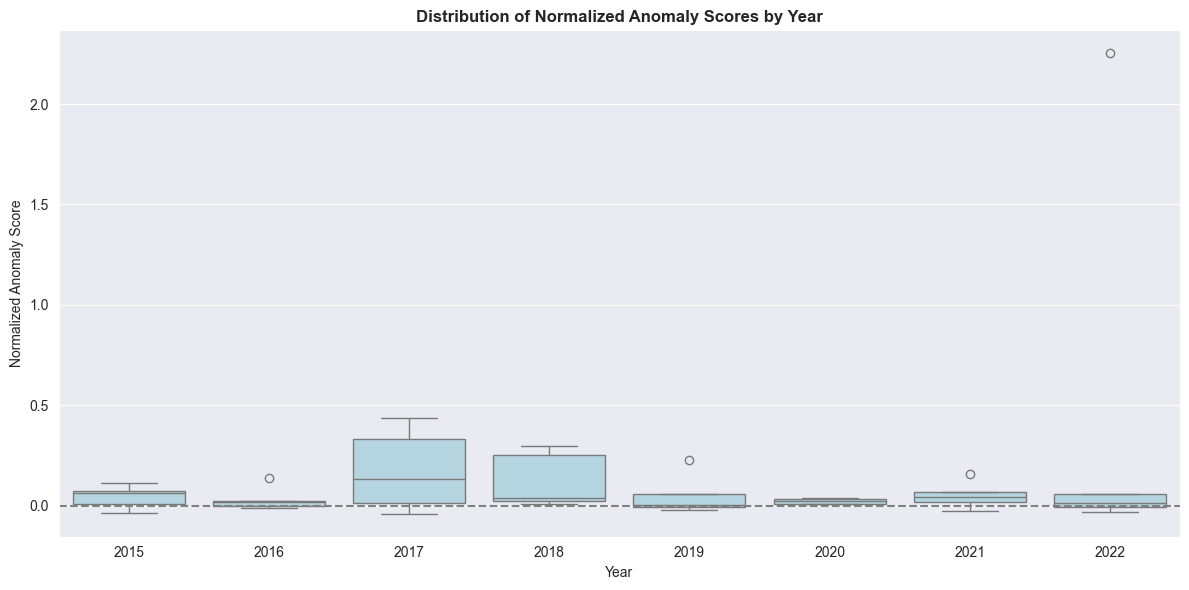

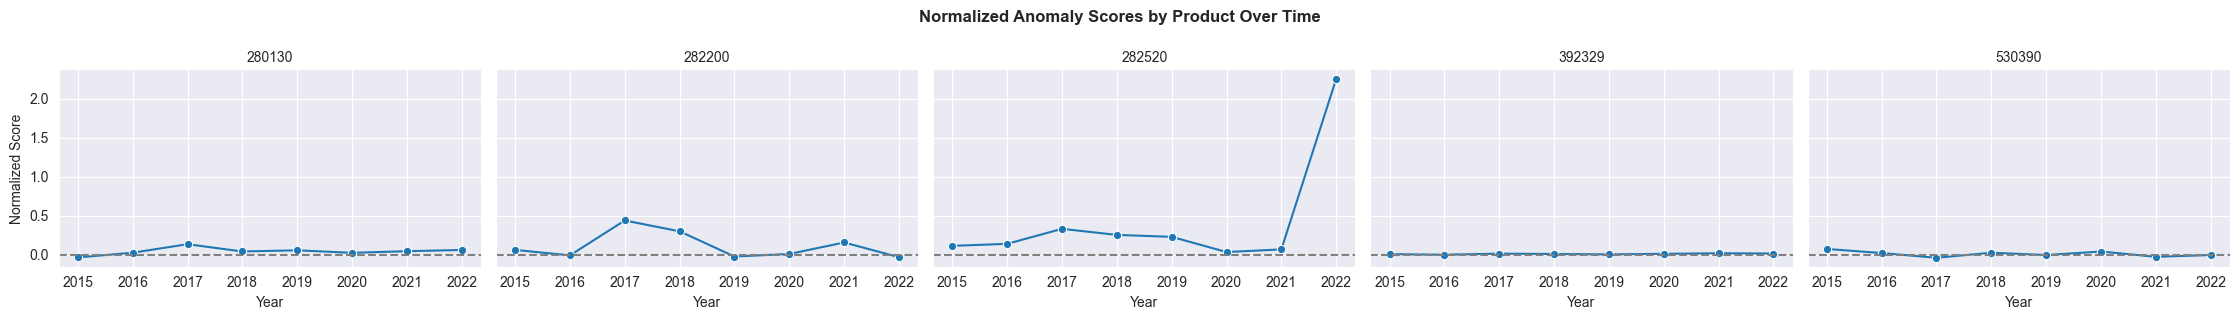

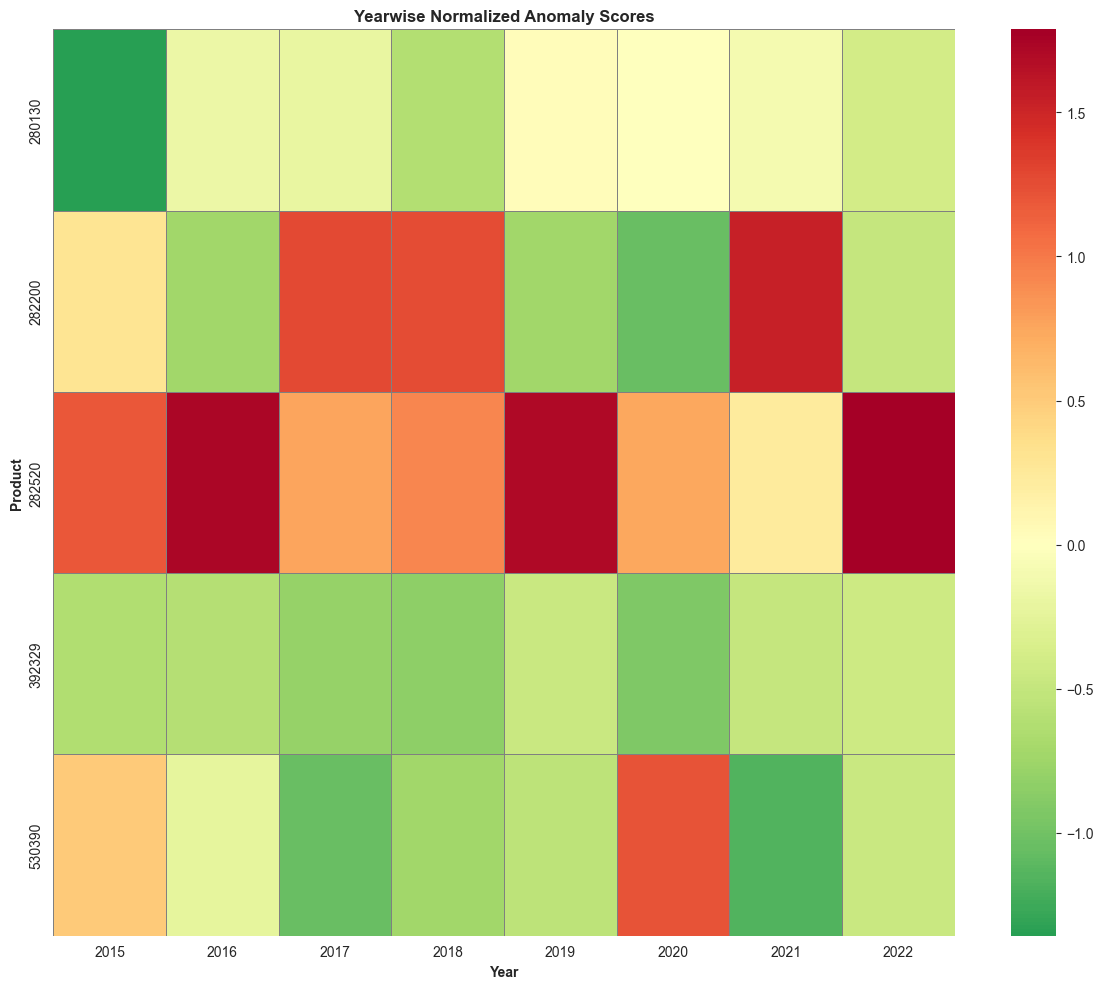

In [48]:
###################################################
# Visualization of Anomaly Scores
###################################################

# Overall distribution of anomaly scores
plt.figure(figsize=(12,6))
sns.boxplot(x="year", y="normalized_anomaly_score", data=results_df, color="lightblue")
plt.axhline(0, color='gray', linestyle='--')
plt.title("Distribution of Normalized Anomaly Scores by Year", fontweight="bold")
plt.xlabel("Year")
plt.ylabel("Normalized Anomaly Score")
plt.tight_layout()
plt.savefig("graphics/boxplot_scores.png", dpi=300)
plt.show()

###################################################

# Trend per product over time
g = sns.FacetGrid(results_df, col="product", col_wrap=5, height=3, aspect=1.5)
g.map(sns.lineplot, "year", "normalized_anomaly_score", marker="o")
g.map(plt.axhline, y=0, color='gray', linestyle='--')
g.set_titles("{col_name}")
g.set_axis_labels("Year", "Normalized Score")
plt.subplots_adjust(top=0.85)
g.fig.suptitle("Normalized Anomaly Scores by Product Over Time", fontweight="bold", y=1.05)
plt.show()

###################################################

# Anomaly score heatmap
custom_cmap = mcolors.LinearSegmentedColormap.from_list(
    'RedGreenRed',
    [(0, 'lightcoral'), (0.5, 'lightgreen'), (1, 'lightcoral')]
)

results_df.sort_values(by=["year"], ascending=True, inplace=True)
pivot_df = results_df.pivot(index="product", columns="year", values="normalized_anomaly_score")

pivot_df_norm = pivot_df.apply(lambda col: (col - col.mean()) / col.std(), axis=0)

plt.figure(figsize=(12, 10))
sns.heatmap(
    pivot_df_norm,
    cmap=custom_cmap,
    center=0,
    annot=False,
    linewidths=0.5,
    linecolor='gray'
)

plt.title("Yearwise Normalized Anomaly Scores", fontweight="bold")
plt.xlabel("Year", fontweight="bold")
plt.ylabel("Product", fontweight="bold")
plt.tight_layout()
plt.savefig("graphics/heatmap_yearwise_scaled.png", dpi=300)
plt.show()

In [ ]:
product_dict = {
    282520: "Lithium",
    280130: "Fluorine",
    271113: "Petroleum",
    760110: "Aluminium",
    750110: "Nickel mattes",
    853400: "Semiconductors",
    721931: "Steel",
    230230: "Wheat",
    180100: "Cocoa Beans",
    270900: "Crude",
    271111: "Natural Gas",
    271129: "Petroleum Gas",
    870323: "Vehicles (mid-sized engine)",
    440729: "Tropical Wood"
}

pivot_df.rename(index=product_dict, inplace=True)

pivot_df_norm = pivot_df.apply(lambda col: (col - col.mean()) / col.std(), axis=0)

plt.figure(figsize=(12, 10))
sns.heatmap(
    pivot_df_norm,
    cmap=custom_cmap,
    center=0,
    annot=False,
    linewidths=0.5,
    linecolor='gray'
)

plt.title("Yearwise Normalized Anomaly Scores", fontweight="bold")
plt.xlabel("Year", fontweight="bold")
plt.ylabel("Product", fontweight="bold")
plt.tight_layout()
plt.savefig("graphics/heatmap_yearwise_scaled.png", dpi=300)
plt.show()